 # ***Model Hyper Search***

#### **Students**
André Silva, r20191226@novaims.unl.pt
Corssino Tchavana, 20220597@novaims.unl.pt
Diogo Silva, 20221393@novaims.unl.pt
Lucas Ferreira, 20220621@novaims.unl.pt

#### **Data Source**
Data Source: https://www.kaggle.com/datasets/alessiocorrado99/animals10?select=raw-img

Cleaned dataset: https://drive.google.com/file/d/1Gjui5aea1H49boW3rwzYJ6NBkBQa9qDC/view?usp=sharing

#### **Summary**

In this dataset the focus is to build a cnn through hyperparameter search and comparison with the handcrafted model.

First the data is loaded.

Then the best model of the hand_crafted notebook is trained to later be compared with the results from this book.

After this 2 cnn's are constructed by performing 2 random searches. The first is based on cnn7 and searches different numeric hyperparameters and only runs 10 trials, while the second is a more in depth random search, with more parameters (including number of layers) and 40 trials.




# **Load Dataset and Data Visualzation**

### **Import**

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics 

import os
import time
import shutil
import random 
import zipfile

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

import cv2
from sklearn.utils import shuffle

from google.colab import drive
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import confusion_matrix
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

### **Load Dataset**

From the drive mount the zipped dataset is grabbed from the google drived.
The dataset was manipulated into creating a testing folder with 120 images for each category.
The names of the categories were also translated to English (as they were in Italian)


In [2]:
# Set the machine
gdrive = True
# Set the connection string
path_aug = "/content/drive/MyDrive/"
main_folder_aug, training_folder, testing_folder = "clean_animals.zip/", "train", "test"
# If using Google Drive
if gdrive:
    # Setup drive
    drive.mount('/content/drive', force_remount=True)        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path_aug + 'clean_animals.zip', 'clean_animals.zip')
    # Extract files
    zip_ = zipfile.ZipFile('clean_animals.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = ""

Mounted at /content/drive
File transfer completed in 11.984 seconds


In [3]:
image_size=(140, 100)
crop_to_aspect_ratio=True
color_mode='rgb'
batch_size=64
label_mode="categorical"
validation_split=0.2
shuffle=True
seed=0

In [4]:
# Generate an object of type tf.data.Dataset 
ds_train = image_dataset_from_directory(
    path + training_folder, 
    image_size=image_size,
    crop_to_aspect_ratio=crop_to_aspect_ratio,
    color_mode=color_mode,
    batch_size=batch_size,
    label_mode=label_mode,
    subset=None,  # Set subset to None to use the entire folder for testing
    validation_split=0,  # Set validation_split to 0
    shuffle=shuffle,
    seed=seed)
# Check object properties
print("\nObject's type:\t", type(ds_train))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train, tf.data.Dataset))
print("Classes:", ds_train.class_names)

Found 43860 files belonging to 10 classes.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [5]:
# Generate an object of type tf.data.Dataset 
ds_test = image_dataset_from_directory(
    path + testing_folder, 
    image_size=image_size,
    crop_to_aspect_ratio=crop_to_aspect_ratio,
    color_mode=color_mode,
    batch_size=batch_size,
    label_mode=label_mode,
    subset=None,  # Set subset to None to use the entire folder for testing
    validation_split=0,  # Set validation_split to 0
    shuffle=False,
    seed=seed
)
# Check object properties
print("\nObject's type:\t", type(ds_test))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_test, tf.data.Dataset))
print("Classes:", ds_test.class_names)

Found 3500 files belonging to 10 classes.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [6]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()
print(batch_x_train.shape, batch_y_train.shape)
print("\nSample of x_train:", batch_x_train[0, 0:2, 0:2, 0])
print("\nSample of y_train:", batch_y_train[0:5])
print("Sample average of y_train:", tf.reduce_mean(batch_y_train))

(64, 140, 100, 3) (64, 10)

Sample of x_train: tf.Tensor(
[[192.      221.38   ]
 [188.      218.67143]], shape=(2, 2), dtype=float32)

Sample of y_train: tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(5, 10), dtype=float32)
Sample average of y_train: tf.Tensor(0.1, shape=(), dtype=float32)


In [7]:
iter_test = iter(ds_test)
batch_x_test, batch_y_test = iter_test.next()
print(batch_x_train.shape, batch_y_train.shape)
print("\nSample of x_train:", batch_x_train[0, 0:2, 0:2, 0])
print("\nSample of y_train:", batch_y_train[0:5])
print("Sample average of y_train:", tf.reduce_mean(batch_y_train))

(64, 140, 100, 3) (64, 10)

Sample of x_train: tf.Tensor(
[[192.      221.38   ]
 [188.      218.67143]], shape=(2, 2), dtype=float32)

Sample of y_train: tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(5, 10), dtype=float32)
Sample average of y_train: tf.Tensor(0.1, shape=(), dtype=float32)


# **CNN Section**


### **CNN7 - layers**

In [ ]:
# Define the model
cnn7 = keras.Sequential([
    layers.Input(shape=(140, 100, 3)),    
    # Data preprocessing
    layers.Rescaling(1./255), 
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.45),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

# Compile the model
cnn7.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Print a summary of the model architecture
cnn7.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_12 (Rescaling)    (None, 140, 100, 3)       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 138, 98, 64)       1792      
                                                                 
 batch_normalization_48 (Bat  (None, 138, 98, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 69, 49, 64)       0         
 g2D)                                                            
                                                                 
 dropout_60 (Dropout)        (None, 69, 49, 64)        0         
                                                                 
 conv2d_49 (Conv2D)          (None, 67, 47, 128)     

In [ ]:
trained = cnn7.fit(ds_train, epochs=21, validation_data=(ds_test))

Epoch 1/21
686/686 [==============================] - 19s 22ms/step - loss: 1.8477 - accuracy: 0.3627 - val_loss: 1.7688 - val_accuracy: 0.3969
Epoch 2/21
686/686 [==============================] - 15s 22ms/step - loss: 1.3556 - accuracy: 0.5267 - val_loss: 2.0898 - val_accuracy: 0.3857
Epoch 3/21
686/686 [==============================] - 15s 22ms/step - loss: 1.1202 - accuracy: 0.6120 - val_loss: 1.4629 - val_accuracy: 0.5269
Epoch 4/21
686/686 [==============================] - 15s 22ms/step - loss: 0.9615 - accuracy: 0.6715 - val_loss: 1.4071 - val_accuracy: 0.5574
Epoch 5/21
686/686 [==============================] - 15s 22ms/step - loss: 0.8371 - accuracy: 0.7128 - val_loss: 1.1752 - val_accuracy: 0.6197
Epoch 6/21
686/686 [==============================] - 15s 22ms/step - loss: 0.7434 - accuracy: 0.7476 - val_loss: 1.3193 - val_accuracy: 0.5751
Epoch 7/21
686/686 [==============================] - 15s 22ms/step - loss: 0.6731 - accuracy: 0.7693 - val_loss: 1.0993 - val_accuracy:

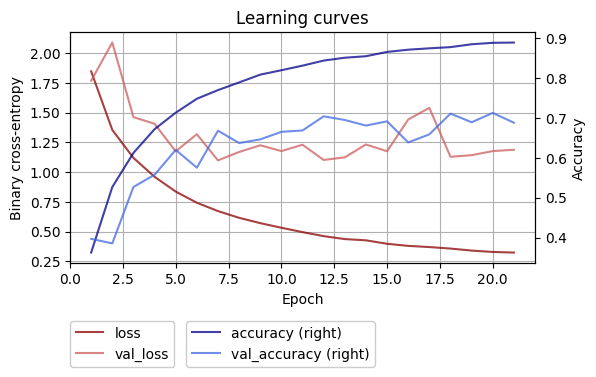

In [ ]:
# Create DataFrame object
df_hist = pd.DataFrame.from_dict(trained.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### **First Search**

In [ ]:
#!pip install keras-tuner

In [15]:
import kerastuner as kt
from tensorflow import keras
from tensorflow.keras import layers

# Define a function to build the CNN model
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(140, 100, 3)))
    model.add(layers.Rescaling(1./255))
    for i in range(hp.Int('num_conv_blocks', 1, 5, default=3)):
        model.add(layers.Conv2D(
            hp.Int(f'filters_{i}', 32, 256, step=32, default=64),
            (3, 3),
            activation='relu'
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(
            hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1, default=0.25)
        ))
    model.add(layers.Flatten())
    model.add(layers.Dense(
        hp.Int('hidden_units', 64, 256, step=32, default=100),
        activation='relu'
    ))
    model.add(layers.Dropout(
        hp.Float('dense_dropout', 0.1, 0.5, step=0.1, default=0.2)
    ))
    model.add(layers.Dense(10, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Define a tuner using RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of trials to run
    executions_per_trial=1,  # Number of executions per trial (use more for better results)
    directory='kerastuner_random_search',  # Directory to store results
    project_name='cnn7'  # Name of the project
)

# Define the data for training and validation
# Assuming you have already loaded and preprocessed your data into ds_train and ds_val

# Start the search
tuner.search(ds_train, epochs=10, validation_data=ds_test)

# Get the best model found during the search
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 03m 24s]
val_accuracy: 0.3505714237689972

Best val_accuracy So Far: 0.699999988079071
Total elapsed time: 00h 32m 17s


In [16]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 140, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 138, 98, 32)       896       
                                                                 
 batch_normalization (BatchN  (None, 138, 98, 32)      128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 69, 49, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 69, 49, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 67, 47, 256)       7

In [17]:
trained = best_model.fit(ds_train, epochs=21, validation_data=(ds_test))

Epoch 1/21
686/686 [==============================] - 21s 24ms/step - loss: 0.4627 - accuracy: 0.8461 - val_loss: 1.0016 - val_accuracy: 0.7151
Epoch 2/21
686/686 [==============================] - 16s 24ms/step - loss: 0.4333 - accuracy: 0.8559 - val_loss: 1.3051 - val_accuracy: 0.6631
Epoch 3/21
686/686 [==============================] - 17s 24ms/step - loss: 0.3998 - accuracy: 0.8653 - val_loss: 0.9147 - val_accuracy: 0.7351
Epoch 4/21
686/686 [==============================] - 16s 24ms/step - loss: 0.3792 - accuracy: 0.8700 - val_loss: 1.0469 - val_accuracy: 0.7137
Epoch 5/21
686/686 [==============================] - 17s 24ms/step - loss: 0.3528 - accuracy: 0.8806 - val_loss: 0.9572 - val_accuracy: 0.7303
Epoch 6/21
686/686 [==============================] - 17s 24ms/step - loss: 0.3344 - accuracy: 0.8873 - val_loss: 0.9282 - val_accuracy: 0.7474
Epoch 7/21
686/686 [==============================] - 17s 24ms/step - loss: 0.3148 - accuracy: 0.8934 - val_loss: 1.3932 - val_accuracy:

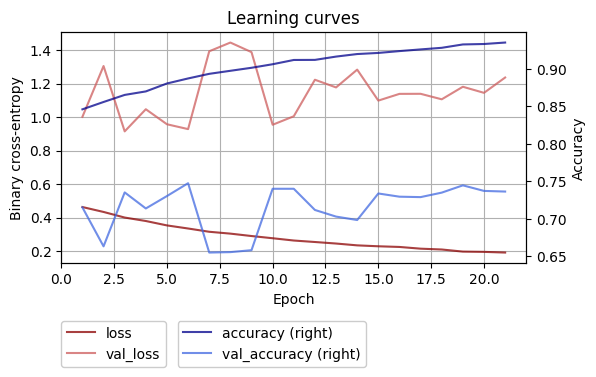

In [18]:
# Create DataFrame object
df_hist = pd.DataFrame.from_dict(trained.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### **Second search**

In [12]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Define hyperparameters
hp = HyperParameters()
hp.Int('num_cnn', 1, 5, default=3)
hp.Int('num_filters', 32, 256, step=32, default=64)
hp.Int('filter_size', 3, 7, step=2, default=3)
hp.Choice('activation', ['relu', 'tanh', 'sigmoid'], default='relu')
hp.Choice('pooling', ['max', 'avg'], default='max')
hp.Float('dropout', 0.1, 0.5, step=0.1, default=0.25)
hp.Float('learning_rate', 1e-5, 1e-2, sampling='log', default=1e-3)
hp.Int('batch_size', 16, 128, step=16, default=32)
hp.Int('epochs', 10, 50, default=20)

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(140, 100, 3)))
    model.add(layers.Rescaling(1./255))

    for i in range(hp.get('num_cnn')):
        model.add(layers.Conv2D(hp.get('num_filters'), (hp.get('filter_size'), hp.get('filter_size')), activation=hp.get('activation')))
        model.add(layers.BatchNormalization())
        if hp.get('pooling') == 'max':
            model.add(layers.MaxPooling2D((2, 2)))
        else:
            model.add(layers.AveragePooling2D((2, 2)))
        model.add(layers.Dropout(hp.get('dropout')))

    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(hp.get('dropout')))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.get('learning_rate')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=40,
    hyperparameters=hp,
    directory='tuner_directory',
    project_name='cnn_tuner')

# Search for the best hyperparameter configuration
tuner.search(ds_train, epochs=21, validation_data=ds_test)


# Get the best model found during the search
best_model = tuner.get_best_models(num_models=1)[0]


Trial 40 Complete [00h 08m 54s]
val_accuracy: 0.10000000149011612

Best val_accuracy So Far: 0.7645714282989502
Total elapsed time: 04h 32m 25s


In [13]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 140, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 138, 98, 224)      6272      
                                                                 
 batch_normalization (BatchN  (None, 138, 98, 224)     896       
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 69, 49, 224)      0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 69, 49, 224)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 67, 47, 224)       4

In [14]:
trained = best_model.fit(ds_train, epochs=21, validation_data=(ds_test))

Epoch 1/21
686/686 [==============================] - 40s 52ms/step - loss: 0.3051 - accuracy: 0.8994 - val_loss: 1.0172 - val_accuracy: 0.7377
Epoch 2/21
686/686 [==============================] - 35s 51ms/step - loss: 0.2936 - accuracy: 0.9031 - val_loss: 1.0263 - val_accuracy: 0.7434
Epoch 3/21
686/686 [==============================] - 36s 52ms/step - loss: 0.2820 - accuracy: 0.9071 - val_loss: 0.8999 - val_accuracy: 0.7694
Epoch 4/21
686/686 [==============================] - 36s 52ms/step - loss: 0.2757 - accuracy: 0.9093 - val_loss: 0.9789 - val_accuracy: 0.7600
Epoch 5/21
686/686 [==============================] - 35s 51ms/step - loss: 0.2669 - accuracy: 0.9115 - val_loss: 1.0608 - val_accuracy: 0.7437
Epoch 6/21
686/686 [==============================] - 36s 52ms/step - loss: 0.2620 - accuracy: 0.9136 - val_loss: 1.0594 - val_accuracy: 0.7546
Epoch 7/21
686/686 [==============================] - 36s 52ms/step - loss: 0.2567 - accuracy: 0.9143 - val_loss: 0.8990 - val_accuracy:

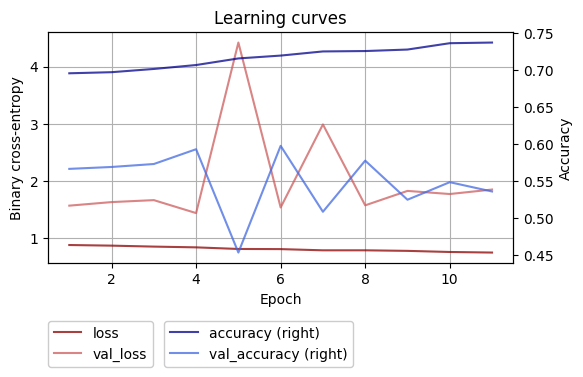

In [19]:
# Create DataFrame object
df_hist = pd.DataFrame.from_dict(trained.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### **Conclusions**

The resulting model from the first search was an improvement on the hand-built model, and the second search resulted in an even better model.

This suggests that hyperparameter seach is a more efficient way of optimizing the parameters than trying to do it by trial and error by hand. It also only needs computational power as the person can be doing something else while the search is running.

Since random searching uses a random sampling technique to randomly sample hyperparameter values from the defined search space, the probability of finding the optimal parameters increase with more parameters and number of repitions, but this also leads to more computanional power needed as well as increases the time needed to run the code - the second search took 9 times more time to run than the first.
If neither time nor computational power are constraints on a project, then the best search to run would likely be greedysearch. It was not used on this notebook as the group has the 2 contraints.